# 5. Evaluation and Comparison of RAG Setups

## 5.1 Setup and Initialization

In [30]:
import nest_asyncio
nest_asyncio.apply()

# Import necessary libraries  
import os  
import json  
import pandas as pd  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.models import VectorizedQuery  
import matplotlib.pyplot as plt  
from datasets import Dataset  
from ragas import evaluate  
from ragas.metrics import AnswerRelevancy, AnswerSimilarity, ContextPrecision  
  
# Load environment variables from .env file  
load_dotenv()  
  
# Get the Azure AI Search details from environment variables  
azure_ai_search_service_name = os.getenv('AZURE_AI_SEARCH_SERVICE_NAME')  
azure_ai_search_admin_key = os.getenv('AZURE_AI_SEARCH_ADMIN_KEY')  
azure_ai_search_endpoint = f"https://{azure_ai_search_service_name}.search.windows.net"  
azure_ai_search_credential = AzureKeyCredential(azure_ai_search_admin_key)  

# Initialize the SearchClient  
index_name = "example-index"  
search_client = SearchClient(endpoint=azure_ai_search_endpoint, index_name=index_name, credential=azure_ai_search_credential)  
  
# Get the Azure OpenAI API details from environment variables  
azure_openai_endpoint = os.getenv('AZURE_OPENAI_ENDPOINT')  
azure_openai_key = os.getenv('AZURE_OPENAI_KEY')  
azure_openai_embedding_model = os.getenv('AZURE_OPENAI_EMBEDDING_MODEL_NAME')  
azure_openai_embedding_deployment = os.getenv('AZURE_OPENAI_EMBEDDING_DEPLOYMENT')  
azure_openai_api_version = os.getenv('AZURE_OPENAI_API_VERSION')  
azure_openai_chat_model_1 = 'gpt-4o'  
azure_openai_chat_model_2 = 'gpt-35-turbo'  
  
# Initialize the Azure OpenAI Client for embedding API  
embedding_client = AzureOpenAI(  
    azure_deployment=azure_openai_embedding_deployment,  
    api_version=azure_openai_api_version,  
    azure_endpoint=azure_openai_endpoint,  
    api_key=azure_openai_key  
)  
  
# Initialize the Azure OpenAI Client for chat API  
chat_client_1 = AzureOpenAI(  
    azure_deployment=azure_openai_chat_model_1,  
    api_version=azure_openai_api_version,  
    azure_endpoint=azure_openai_endpoint,  
    api_key=azure_openai_key  
)  
  
chat_client_2 = AzureOpenAI(  
    azure_deployment=azure_openai_chat_model_2,  
    api_version=azure_openai_api_version,  
    azure_endpoint=azure_openai_endpoint,  
    api_key=azure_openai_key  
)  

## 5.2 Load Data

In [31]:
# Load the JSON file containing question, contexts, and ground_truth  
with open('evaluation_data.json', 'r', encoding='utf-8') as f:  
    data = json.load(f)  

## 5.3 Define Helper Functions

In [32]:
# Function to retrieve context from indexed documents  
def retrieve_context(query, client, search_client, top_k=3):  
    embedding = get_embedding(query, client)  
    vector_query = VectorizedQuery(vector=embedding, k_nearest_neighbors=top_k, fields="contentVector")  
    results = search_client.search(  
        search_text=None,  
        vector_queries=[vector_query],  
        top=top_k  
    )  
    context = ""  
    for result in results:  
        context += result['content'] + "\n"  
    return context  
  
# Function to generate embeddings using Azure OpenAI API  
def get_embedding(text, client):  
    response = client.embeddings.create(input=text, model=azure_openai_embedding_model)  
    return response.data[0].embedding  
  
# Function to generate answers using a specified RAG setup  
def generate_answer(query, context, client, model_name):  
    messages = [  
        {"role": "system", "content": "You are a knowledgeable assistant that provides accurate and helpful information."},  
        {"role": "user", "content": query},  
        {"role": "assistant", "content": context}  
    ]  
    response = client.chat.completions.create(  
        model=model_name,  # Use the chat model specified  
        messages=messages,  
        max_tokens=150,  
        n=1,  
        stop=None,  
        temperature=0.7  
    )  
    return response.choices[0].message.content.strip()  
  
# Function to prepare the dataset for evaluation  
def prepare_dataset(questions, generated_answers, ground_truths, contexts):  
    return {  
        'question': questions,  
        'answer': generated_answers,  
        'ground_truth': ground_truths,  
        'contexts': contexts  
    }  

from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings

azure_model = AzureChatOpenAI(
    openai_api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    azure_deployment='gpt-4o',
    model='gpt-4o',
    validate_base_url=False,
    api_key=azure_openai_key
)

# init the embeddings for answer_relevancy, answer_correctness and answer_similarity
azure_embeddings = AzureOpenAIEmbeddings(
    openai_api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=azure_openai_embedding_deployment,
    model=azure_openai_embedding_model,
    api_key=azure_openai_key
)
  
# Function to evaluate the generated answers using RAGAS library  
def evaluate_answers(questions, generated_answers, ground_truths, contexts):  
    dataset_dict = prepare_dataset(questions, generated_answers, ground_truths, contexts)  
    dataset = Dataset.from_dict(dataset_dict)  
    metrics = [  
        AnswerRelevancy(),   
        AnswerSimilarity(),   
        ContextPrecision()  
    ]  # Replace with actual metrics you want to use  
    results = evaluate(
        dataset=dataset, 
        metrics=metrics,
        llm=azure_model,
        embeddings=azure_embeddings
    )

    return results  

## 5.4 Generate Answers

In [33]:
# Generate AI answers using the first RAG setup (e.g., gpt-4)  
generated_answers_1 = []  
for question, context_list in zip(data['question'], data['contexts']):  
    context = " ".join(context_list)  # Combine all context strings into one  
    answer = generate_answer(question, context, chat_client_1, azure_openai_chat_model_1)  
    generated_answers_1.append(answer)  
  
# Generate AI answers using the second RAG setup (e.g., gpt-3.5)  
generated_answers_2 = []  
for question, context_list in zip(data['question'], data['contexts']):  
    context = " ".join(context_list)  # Combine all context strings into one  
    answer = generate_answer(question, context, chat_client_2, azure_openai_chat_model_2)  
    generated_answers_2.append(answer)  

## 5.5 Evaluate and Compare

In [34]:
# Evaluate the generated answers for both RAG setups  
evaluations_1 = evaluate_answers(data['question'], generated_answers_1, data['ground_truth'], data['contexts'])  
evaluations_2 = evaluate_answers(data['question'], generated_answers_2, data['ground_truth'], data['contexts'])  

Evaluating: 100%|██████████| 192/192 [00:58<00:00,  3.29it/s]


## 5.6 Visualize Results

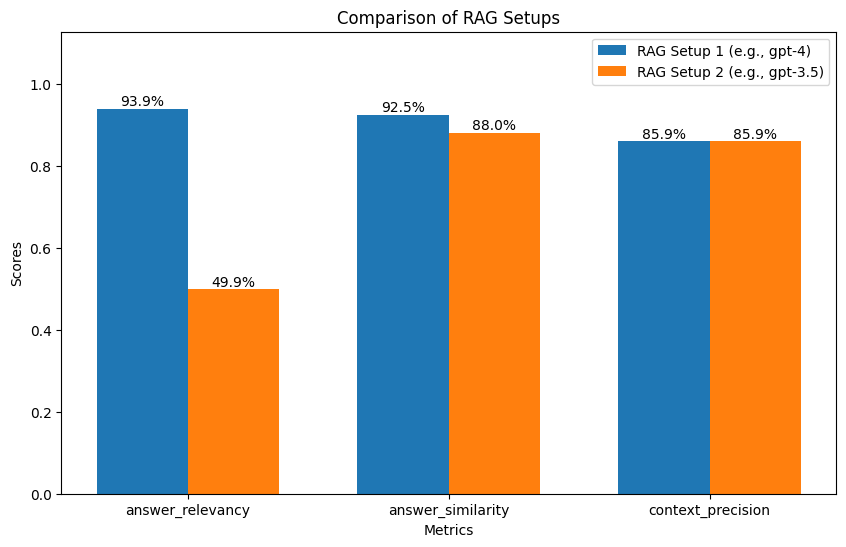

In [38]:
# Extract metrics and values
metrics = list(evaluations_1.keys())
values_1 = list(evaluations_1.values())
values_2 = list(evaluations_2.values())

# Plot the evaluation metrics for both RAG setups side-by-side for comparison
x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, values_1, width, label='RAG Setup 1 (e.g., gpt-4)')
ax.bar([p + width for p in x], values_2, width, label='RAG Setup 2 (e.g., gpt-3.5)')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of RAG Setups')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(metrics)
ax.set_ylim(0, max(max(values_1), max(values_2)) * 1.2)
ax.legend()

# Add values on top of the bars
for i, v1, v2 in zip(x, values_1, values_2):
    ax.text(i, v1, f"{round(v1 * 100, 1)}%", ha='center', va='bottom')
    ax.text(i + width, v2, f"{round(v2 * 100, 1)}%", ha='center', va='bottom')

# Show the plot
plt.show()
